# Le modèle EfficientNetB0 

## Un peu d’histoire

EfficientNet est une famille de modèles de réseaux de neurones convolutionnels proposée en 2019 par les chercheurs de Google Brain, en particulier Mingxing Tan et Quoc V. Le. Leur publication, *EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks*, a introduit une méthode systématique pour améliorer à la fois **la précision** et **l’efficacité** d’un réseau.

L'idée fondatrice d’EfficientNet repose sur le **scaling uniforme** du modèle : au lieu d’augmenter uniquement la profondeur, la largeur ou la résolution de l’entrée indépendamment, ils proposent une approche équilibrée pour les trois à la fois. Cela permet d’obtenir un excellent compromis entre **performances** et **coût computationnel**.

Le plus petit modèle de la famille, **EfficientNetB0**, a été conçu grâce à une technique appelée **Neural Architecture Search** (NAS), qui automatise la recherche d’architecture optimale.

## ImageNet

ImageNet est une gigantesque base de données de plus de 14 millions d’images labellisées réparties dans plus de 1000 classes, en 2014. En 2007, une chercheuse du nom de Fei-Fei Li a commencé à travailler sur l’idée de créer un tel jeu de données. Certes la modélisation est un aspect très important pour obtenir des bonnes performances, mais disposer de données de grande qualité l’est tout autant pour avoir un apprentissage de qualité. Les données ont été collectées et étiquetées depuis le web par des humains. Elles sont donc open source et n’appartiennent pas à une entreprise en particulier. 

Depuis 2010 s’organise, chaque année, une compétition ImageNet Large Scale Visual Recognition Challenge dont le but est de challenger des modèles de traitement d’images. La compétition s’effectue sur un sous-ensemble d’ImageNet composé de : 1,2 million d’images d’entraînement, 50000 pour validation et 150000 pour tester le modèle.

## EfficientNetB0

EfficientNetB0 se compose de plusieurs blocs de convolution appelés **MBConv (Mobile Inverted Bottleneck Conv)**, initialement utilisés dans MobileNetV2. Ces blocs intègrent :
- des couches de convolution 1x1 pour expansion,
- des convolutions **depthwise** (très légères),
- des **squeeze-and-excitation blocks** (mécanisme d’attention léger),
- une réduction via des convolutions 1x1,
- des résidus (skip connections).

La structure complète d’EfficientNetB0 est optimisée pour être utilisée **sur mobile**, tout en gardant une excellente performance sur des tâches complexes.

## Résumé

Dans ce projet, EfficientNetB0 est utilisé comme **extracteur de caractéristiques** pour des images médicales de radiographie thoracique.

Ses avantages sont :
- **Excellent rapport précision / poids du modèle**, idéal pour un environnement à ressources limitées (GPU moyen ou CPU),
- **Backbone pré-entraîné** sur ImageNet, réutilisable via transfert d’apprentissage,
- **Capacité à extraire des motifs visuels complexes**, utiles pour détecter des pathologies pulmonaires.

Nous utiliserons d’abord EfficientNetB0 en mode "gelé" (`trainable = False`), puis nous explorerons le **fine-tuning** sur les couches profondes pour affiner ses performances sur notre jeu de données.


## Bibliographie

- [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946) — Article original de Google Brain (2019)
- [Keras Documentation – EfficientNet](https://keras.io/api/applications/efficientnet/) — API officielle de Keras
- [PyTorch Hub – EfficientNet (NVIDIA)](https://pytorch.org/hub/nvidia_deeplearningexamples_efficientnet/) — Implémentation PyTorch optimisée par NVIDIA
- [Medium – EfficientNet: Scaling Depth, Width & Resolution](https://medium.com/@danushidk507/efficientnet-scaling-depth-width-resolution-11e2d4311357) — Article de vulgarisation sur le scaling compound
- [ImageNet](https://www.image-net.org/) — Jeu de données de référence utilisé pour l’entraînement initial d’EfficientNet
- [Page Wikipedia française de Imagenet](https://fr.wikipedia.org/wiki/ImageNet)
- [Page Wikipedia angalise de Imagenet](https://en.wikipedia.org/wiki/ImageNet)

In [19]:
import os
import pathlib
import sys
import cv2

import numpy as np
import pandas as pd
from enum import Enum, auto

# Divers utilitaires
from collections import defaultdict
from tqdm import tqdm 

# Bibliothèques Keras / Tensorflow
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.mixed_precision import set_global_policy
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Outils de machine learning classique
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Visualisation des données
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


## Fonctions utilitaires

Avant de passer à la partie modélisation, ce notebook regroupe ici un ensemble de **fonctions utilitaires** qui seront utilisées tout au long du pipeline.

Ces fonctions permettent :
- d’organiser et charger les données,
- de créer les générateurs d’images pour l’entraînement,
- de visualiser des métriques ou images,
- d’afficher la matrice de confusion finale.

In [5]:
def plot_confusion_matrix(cm, labels, normalize=False, title="Matrice de confusion", cmap="coolwarm"):
    """
    Affiche une matrice de confusion à l'aide de Seaborn.

    Args:
        cm (array): Matrice de confusion.
        labels (list): Liste des noms de classes (ordonnées et abscisses).
        normalize (bool): Si True, normalise par ligne et affiche les pourcentages.
        title (str): Titre du graphique.
        cmap (str): Palette de couleurs.
    """
    if normalize:
        # Normalisation ligne par ligne
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = ".2%"  # Affichage sous forme de pourcentage XX.XX%
    else:
        fmt = "d"  # Entiers bruts

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=labels, yticklabels=labels)

    plt.title(title)
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.tight_layout()


In [7]:
def epoch_viewer(model, style="whitegrid", engine="seaborn"):
    """
    Affiche les courbes d'apprentissage (accuracy et perte) à partir de l'historique du modèle.

    Args:
        model: objet Keras avec un attribut .history contenant les métriques.
        style: style graphique pour Seaborn.
        engine: "seaborn" (par défaut) ou "plotly" pour une visualisation interactive.
    """
    history = model.history

    if engine == "plotly": 
        if "plotly" not in sys.modules:
            print("Plotly non installé, utilisation de Seaborn")
        else:
            fig = make_subplots(rows=1, cols=2, subplot_titles=["Accuracy", "Loss"])

            # Accuracy
            fig.add_trace(go.Scatter(x=list(range(len(history["accuracy"]))), y=history["accuracy"],
                                     mode="lines", name="Train Accuracy"), row=1, col=1)
            fig.add_trace(go.Scatter(x=list(range(len(history["val_accuracy"]))), y=history["val_accuracy"],
                                     mode="lines", name="Validation Accuracy"), row=1, col=1)

            # Loss
            fig.add_trace(go.Scatter(x=list(range(len(history["loss"]))), y=history["loss"],
                                     mode="lines", name="Train Loss"), row=1, col=2)
            fig.add_trace(go.Scatter(x=list(range(len(history["val_loss"]))), y=history["val_loss"],
                                     mode="lines", name="Validation Loss"), row=1, col=2)

            fig.update_layout(height=600, width=1500, title_text="Historique d'entraînement", template="plotly_white")
            fig.show()
            return
        
    # Affichage classique avec seaborn
    sns.set_theme(style=style)
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))

    sns.lineplot(model.history['accuracy'], color="blue", label="acc", ax=ax[0])
    sns.lineplot(model.history['val_accuracy'], color="red", label="val acc", ax=ax[0])
    ax[0].legend()
    ax[0].set_title("Accuracy")

    sns.lineplot(model.history['loss'], color="blue", label="loss", ax=ax[1])
    sns.lineplot(model.history['val_loss'], color="red", label="val loss", ax=ax[1])
    ax[1].legend()
    ax[1].set_title("Los_accuracy")


In [8]:
def define_paths(data_dir, exclude_dirs=None, exclude_files=None):
    """
    Définit les chemins de fichiers et leurs étiquettes (labels) à partir d’un
    dossier principal. Possibilité d’exclure certains dossiers ou fichiers.

    Arguments :
        data_dir (str) : Chemin vers le dossier de données principal.
        exclude_dirs (list, optionnel) : Liste de noms de dossiers à exclure.
                                         Exemple : ['a_exclure'].
        exclude_files (list, optionnel) : Liste de fichiers à exclure (noms simples, sans chemin).
                                          Exemple : ['image_bug.jpg'].

    Retourne :
        tuple :
            - filepaths (list) : Liste des chemins absolus vers les fichiers valides.
            - labels (list) : Liste des étiquettes correspondantes (noms des dossiers parents).
    """
    filepaths = []
    labels = []

    # Si aucune liste d'exclusion n'est fournie, on utilise des listes vides
    if exclude_dirs is None:
        exclude_dirs = []
    if exclude_files is None:
        exclude_files = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)

        # Sauter les dossiers explicitement exclus
        if fold in exclude_dirs:
            print(f"Dossier exclu : {foldpath}")
            continue

        # Sauter les fichiers à la racine du dossier (on attend uniquement des sous-dossiers)
        if pathlib.Path(foldpath).suffix != '':
            continue

        # Liste des fichiers dans le dossier courant
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            file_basename = os.path.basename(fpath)

            # Exclure certains fichiers spécifiquement
            if file_basename in exclude_files:
                print(f"Fichier exclu : {fpath}")
                continue

            # Si on tombe sur un sous-dossier (par exemple "masks")
            if pathlib.Path(fpath).suffix == '':
                if pathlib.Path(fpath).parts[-1].lower() == 'masks':
                    print(f"Dossier de masques ignoré : {fpath}")
                    continue
                else:
                    # Parcours du contenu du sous-dossier
                    o_file = os.listdir(fpath)
                    for f in o_file:
                        ipath = os.path.join(fpath, f)
                        inner_file_basename = os.path.basename(ipath)

                        # Exclusion spécifique de fichiers internes
                        if inner_file_basename in exclude_files:
                            print(f"Fichier exclu (interne) : {ipath}")
                            continue

                        filepaths.append(ipath)
                        labels.append(fold)  # Étiquette = nom du dossier parent
            else:
                # Fichier directement dans le dossier principal
                filepaths.append(fpath)
                labels.append(fold)

    return filepaths, labels



def define_df(files, classes):
    """
    Crée un DataFrame pandas à partir de deux listes : les chemins et les labels.

    Arguments :
        files (list) : Liste des chemins vers les fichiers.
        classes (list) : Liste des étiquettes associées.

    Retourne :
        pd.DataFrame : Un tableau avec deux colonnes : 'filepaths' et 'labels'.
    """
    Fseries = pd.Series(files, name="filepaths")
    Lseries = pd.Series(classes, name="labels")
    return pd.concat([Fseries, Lseries], axis=1)



def split_data(data_dir, exclude_dirs=None, exclude_files=None):
    """
    Divise l'ensemble des données en trois sous-ensembles : entraînement, validation et test.

    Arguments :
        data_dir (str) : Chemin vers le dossier principal contenant les données.
        exclude_dirs (list, optionnel) : Dossiers à ignorer.
        exclude_files (list, optionnel) : Fichiers à ignorer.

    Retourne :
        tuple :
            - train_df : Données pour l'entraînement.
            - valid_df : Données pour la validation.
            - test_df : Données pour le test final.
    """
    # Création des chemins de fichiers + labels (avec exclusions éventuelles)
    files, classes = define_paths(data_dir, exclude_dirs=exclude_dirs, exclude_files=exclude_files)
    df = define_df(files, classes)

    # Séparation en données d'entraînement et données restantes (20%)
    strat = df['labels']
    train_df, dummy_df = train_test_split(
        df, train_size=0.8, shuffle=True, random_state=123, stratify=strat
    )

    # Séparation des 20% restants en validation et test
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(
        dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat
    )

    return train_df, valid_df, test_df


In [9]:
def create_gens(train_df, valid_df, test_df, batch_size, img_size=(240, 240)):
    """
    Crée les générateurs d'images pour l'entraînement, la validation et le test.

    Args:
        train_df (DataFrame): DataFrame pour les images d'entraînement.
        valid_df (DataFrame): DataFrame pour la validation.
        test_df (DataFrame): DataFrame pour le test.
        batch_size (int): Taille des lots.
        img_size (tuple): Dimensions des images cibles (hauteur, largeur).

    Retourne :
        train_gen, valid_gen, test_gen : les 3 générateurs d'images prêts à l'emploi.
    """
    print(img_size)
    channels = 3
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Calcul dynamique d'une taille de batch test qui divise bien le dataset (max 80 batches)
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1)
                                  if ts_length % n == 0 and ts_length / n <= 80]))
    test_steps = ts_length // test_batch_size

    # Préparation des générateurs avec et sans augmentation
    tr_gen = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True)
    ts_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_gen = tr_gen.flow_from_dataframe(
        train_df, x_col="filepaths", y_col="labels",
        target_size=img_size, class_mode="sparse", color_mode=color,
        shuffle=True, batch_size=batch_size
    )

    valid_gen = ts_gen.flow_from_dataframe(
        valid_df, x_col="filepaths", y_col="labels",
        target_size=img_size, class_mode="sparse", color_mode=color,
        shuffle=False, batch_size=batch_size
    )

    test_gen = ts_gen.flow_from_dataframe(
        test_df, x_col="filepaths", y_col="labels",
        target_size=img_size, class_mode="sparse", color_mode=color,
        shuffle=False, batch_size=test_batch_size
    )

    return train_gen, valid_gen, test_gen


In [6]:
def show_images(gen, figsize=(20, 20), class_names=None):
    """
    Affiche jusqu'à 25 images avec leur label à partir d'un générateur.

    Args:
        gen: Un générateur Keras (ImageDataGenerator).
        figsize (tuple): Taille de la figure matplotlib.
        class_names (list, optionnel): Liste des noms de classes (si labels sont des indices).
    """
    try:
        images, labels = next(gen)  # Batch suivant
    except TypeError:
        images, labels = gen[0]     # Si Sequence personnalisée

    sample = min(len(labels), 25)

    # Conversion éventuelle des indices en noms de classes
    if hasattr(gen, 'class_indices'):
        idx_to_class = {v: k for k, v in gen.class_indices.items()}
    elif class_names:
        idx_to_class = {i: name for i, name in enumerate(class_names)}
    else:
        idx_to_class = None

    plt.figure(figsize=figsize)

    for i in range(sample):
        plt.subplot(5, 5, i + 1)

        img = images[i]
        if img.max() > 1.5:
            img = img / 255.0  # Normalisation éventuelle

        plt.imshow(img)

        if idx_to_class:
            if labels.ndim == 2:
                label_idx = np.argmax(labels[i])  # One-hot
            else:
                label_idx = int(labels[i])        # Sparse
            title = idx_to_class.get(label_idx, str(label_idx))
        else:
            title = str(labels[i])

        plt.title(title, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [10]:
def generate_datas(img_size=(240, 240), exclude_dirs=None):
    """
    Génére les générateurs de données d'entraînement, validation et test.

    Args:
        img_size (tuple): Dimensions des images (largeur, hauteur).
        exclude_dirs (list, optionnel): Liste de dossiers à exclure.

    Retourne :
        tuple : (train_gen, valid_gen, test_gen)
    """
    data_dir = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'
    
    try:
        train_df, valid_df, test_df = split_data(data_dir, exclude_dirs=exclude_dirs)
        batch_size = 16
        train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size, img_size=img_size)
        return train_gen, valid_gen, test_gen
    except:
        print('Entrée invalide')
        return None, None, None


## Chargement des données complètes

Dans ce premier essai, nous chargeons **l'ensemble complet des données**, incluant les 4 types suivants :

- `COVID`
- `Normal`
- `Viral Pneumonia`
- `Lung Opacity`

Le groupe **Lung Opacity**, moins bien défini cliniquement, sera **exclu dans un second temps** pour une version affinée du modèle.  
Cela permet de tester d’abord le comportement du modèle sur le **jeu de données complet**, avant de le spécialiser.


In [9]:
train_gen, valid_gen, test_gen = generate_datas(exclude_dirs=None)

Skipping masks directory: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks
Skipping masks directory: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/masks
Skipping masks directory: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/masks
Skipping masks directory: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/masks
(240, 240)
Found 16932 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.


In [10]:
def build_efficentnet_model(input_shape=(240, 240, 3), num_classes=4, fine_tune=False):
    """
    Crée un modèle EfficientNetB0 

    Args:
        input_shape (tuple): Forme des images en entrée.
        num_classes (int): Nombre de classes de sortie.
        fine_tune (bool): Si True, on dégele le backbone pour l'affinage.

    Retourne :
        Keras Model compilé (non entraîné).
    """
    base_model = EfficientNetB0(include_top=False, weights="imagenet",
                                input_shape=input_shape, pooling='max')
    base_model.trainable = False  # Backbone gelé dans cette version

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(rate=0.5, seed=123)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs=x)
    return model


## Compilation et entraînement du modèle

On compile le modèle avec :
- une **perte adaptée à la classification multi-classe** (`sparse_categorical_crossentropy`),
- un **optimiseur Adam** avec un taux d’apprentissage modéré (`1e-4`),
- la **métrique d’accuracy** classique.

Deux callbacks sont utilisés :
- `EarlyStopping` : pour arrêter l'entraînement si la validation n'améliore plus.
- `ReduceLROnPlateau` : pour réduire le `learning rate` si la validation stagne.

On utilise également des **poids de classes** calculés automatiquement
pour compenser le déséquilibre entre les classes.

In [13]:
model = build_efficentnet_model(input_shape=(240, 240, 3))
model.summary()

I0000 00:00:1749474214.717422      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749474214.718101      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,383,655 (16.72 MB)

 Trainable params: 331,524 (1.26 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [15]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks
early_stopping = EarlyStopping(
    patience=5, min_delta=0.01, mode="min",
    monitor="val_loss", restore_best_weights=True
)

reduce_learning_rate = ReduceLROnPlateau(
    monitor="val_loss", patience=3, min_delta=0.01,
    factor=0.1, cooldown=4
)

# Poids de classes pour corriger les déséquilibres
train_labels = train_gen.classes
class_labels = np.unique(train_labels)
class_weights = class_weight.compute_class_weight(
    class_weight="balanced", classes=class_labels, y=train_labels
)
class_weights_dict = dict(zip(class_labels, class_weights))

# Entraînement
epochs = 10
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_learning_rate]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1749474324.980271      97 service.cc:148] XLA service 0x7a3588002660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749474324.981263      97 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749474324.981289      97 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749474327.162159      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1059 ━━━━━━━━━━━━━━━━━━━━ 8:30:19 29s/step - accuracy: 0.1875 - loss: 3.0259

I0000 00:00:1749474337.094891      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1059/1059 ━━━━━━━━━━━━━━━━━━━━ 189s 152ms/step - accuracy: 0.5673 - loss: 1.0082 - val_accuracy: 0.8181 - val_loss: 0.4790 - learning_rate: 1.0000e-04
Epoch 2/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 67s 63ms/step - accuracy: 0.7526 - loss: 0.5322 - val_accuracy: 0.8398 - val_loss: 0.4239 - learning_rate: 1.0000e-04
Epoch 3/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 66s 62ms/step - accuracy: 0.8057 - loss: 0.4154 - val_accuracy: 0.8516 - val_loss: 0.3910 - learning_rate: 1.0000e-04
Epoch 4/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 64s 61ms/step - accuracy: 0.8158 - loss: 0.3851 - val_accuracy: 0.8596 - val_loss: 0.3643 - learning_rate: 1.0000e-04
Epoch 5/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 64s 60ms/step - accuracy: 0.8327 - loss: 0.3435 - val_accuracy: 0.8629 - val_loss: 0.3507 - learning_rate: 1.0000e-04
Epoch 6/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 64s 60ms/step - accuracy: 0.8412 - loss: 0.3328 - val_accuracy: 0.8705 - val_loss: 0.3364 - learning_rate: 1.0000e-04
Epoch 7/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 63s 60m

## Visualisation des courbes d’apprentissage

On affiche ici l’évolution de l’accuracy et de la loss sur les données
d'entraînement et de validation à chaque époque.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

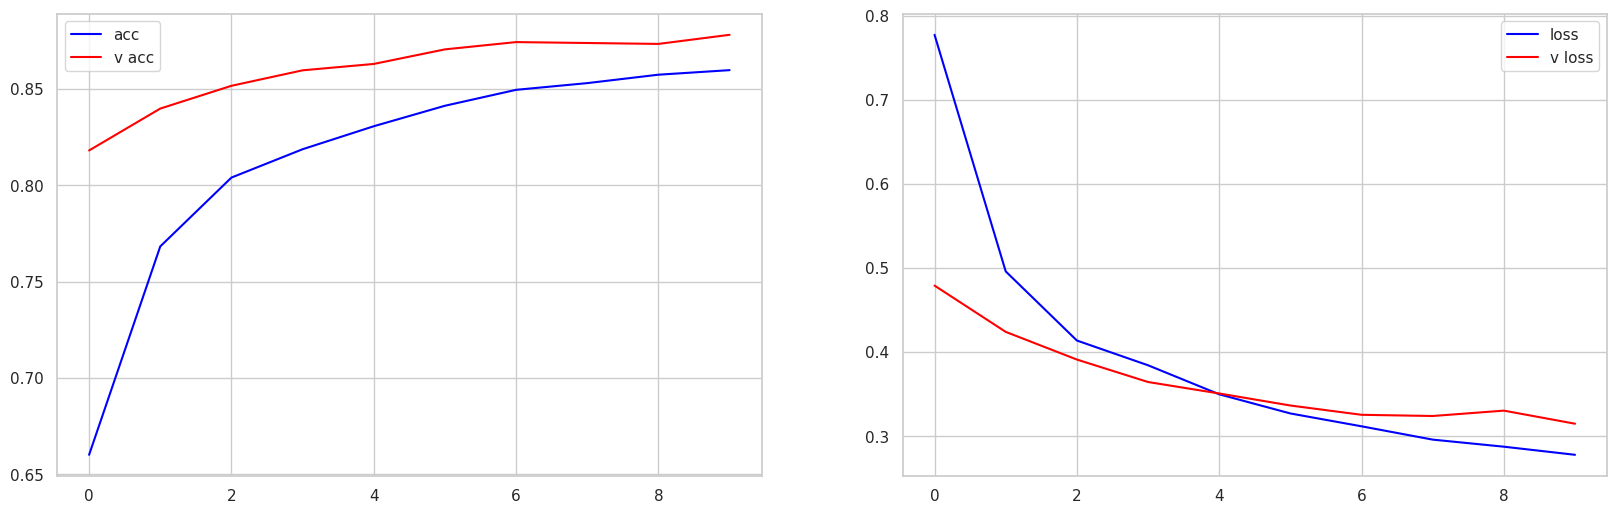

In [16]:
epoch_viewer(history)

In [17]:
true_labels = valid_gen.classes

# Prédictions
pred_probs = model.predict(valid_gen)
pred_labels = np.argmax(pred_probs, axis=1)

# Sauvegarde du modèle
model.save("resnet_base_model.h5")

# Rapport
target_names = list(valid_gen.class_indices.keys())
print("Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=target_names))

133/133 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step
Classification Report:

                 precision    recall  f1-score   support

          COVID       0.84      0.93      0.88       361
   Lung_Opacity       0.84      0.82      0.83       601
         Normal       0.91      0.88      0.89      1019
Viral Pneumonia       0.96      0.98      0.97       135

       accuracy                           0.88      2116
      macro avg       0.89      0.90      0.89      2116
   weighted avg       0.88      0.88      0.88      2116



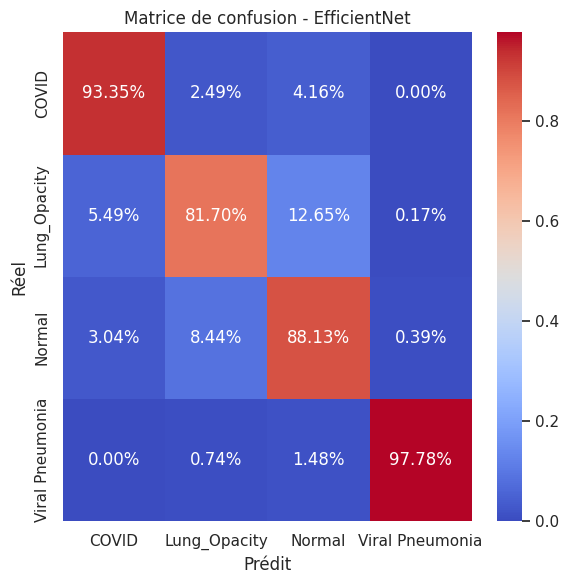

In [26]:
cm = confusion_matrix(true_labels, pred_labels)
labels = target_names

plot_confusion_matrix(cm, labels, normalize=True, title="Matrice de confusion - EfficientNet", cmap="coolwarm")

## Tuning des hyperparamètres avec Keras Tuner

L'entraînement d'un modèle ne dépend pas uniquement de son architecture, mais aussi d'un ensemble de **paramètres externes** appelés **hyperparamètres** :
- la taille des couches (`Dense`),
- les taux de `dropout`,
- le `learning rate` de l’optimiseur,
- l’activation du `fine-tuning` du modèle pré-entraîné...

Ces hyperparamètres **ne sont pas appris automatiquement**. Il faut donc les **chercher manuellement ou automatiquement**.

C’est ici qu’intervient **Keras Tuner**, une bibliothèque développée par les équipes de Keras/TensorFlow pour **automatiser la recherche des meilleures combinaisons d’hyperparamètres**.

Il existe plusieurs stratégies de recherche :
- **RandomSearch** : sélectionne aléatoirement un ensemble de configurations,
- **Hyperband** : stratégie intelligente basée sur la performance précoce,
- (et d'autres comme BayesianOptimization).

Keras Tuner permet ainsi de **tester plusieurs modèles différents automatiquement**, et de sélectionner celui qui obtient les meilleures performances sur un jeu de validation.

Dans la suite, nous allons utiliser cette méthode pour ajuster dynamiquement notre modèle EfficientNet.

In [27]:
def build_efficientnet_tuner(hp):
    input_shape = (240, 240, 3)
    num_classes = 3

    inputs = Input(shape=input_shape)

    # Crée le modèle de base avec input_tensor pour conserver les connexions
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        pooling='max'
    )
    base_model.trainable = hp.Boolean("fine_tune", default=False)

    # Utilise base_model.output pour garantir l'intégration complète
    x = base_model.output
    x = BatchNormalization()(x)

    # Couches denses avec hyperparamètres
    x = Dense(
        units=hp.Int('dense_1', min_value=512, max_value=4096, step=512),
        activation='relu'
    )(x)
    x = Dropout(hp.Float('dropout_1', 0.2, 0.6, step=0.1))(x)

    x = Dense(
        units=hp.Int('dense_2', min_value=128, max_value=2048, step=128),
        activation='relu'
    )(x)
    x = Dropout(hp.Float('dropout_2', 0.2, 0.6, step=0.1))(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Apprentissage
    lr = hp.Choice('lr', [1e-4, 3e-4, 1e-3])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model
tuner = RandomSearch(
    build_efficientnet_tuner,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_logs',
    project_name='effnet_tuning'
)


In [28]:
tuner = RandomSearch(
    build_efficientnet_tuner,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_logs',
    project_name='effnet_tuning'
)


In [11]:
train_gen, valid_gen, test_gen = generate_datas(exclude_dirs="Lung_Opacity")

Dossier de masques ignoré : /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks
Dossier exclu : /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity
Dossier de masques ignoré : /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/masks
Dossier de masques ignoré : /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/masks
(240, 240)
Found 12122 validated image filenames belonging to 3 classes.
Found 1515 validated image filenames belonging to 3 classes.
Found 1516 validated image filenames belonging to 3 classes.


In [31]:
tuner.search(
    train_gen,
    validation_data=valid_gen,
    epochs=5,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)]
)


Trial 10 Complete [00h 04m 30s]
val_accuracy: 0.961056113243103

Best val_accuracy So Far: 0.9867987036705017
Total elapsed time: 01h 01m 04s


In [32]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 440 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 240, 240, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 240, 240, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 240, 240, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 240, 240, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 241, 241, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 120, 120, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 120, 120, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 120, 120, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 120, 120, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 120, 120, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 120, 120, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 5,701,286 (21.75 MB)

 Trainable params: 5,656,703 (21.58 MB)

 Non-trainable params: 44,583 (174.16 KB)

In [33]:
early_stopping = EarlyStopping(patience=5, min_delta=0.001, mode="min", monitor="val_loss", restore_best_weights=True)

reduce_learning_rate = ReduceLROnPlateau(monitor="val_loss", patience=3, min_delta=0.01, factor=0.1, cooldown=4)

train_labels = train_gen.classes
class_labels = np.unique(train_labels) 
class_weights = class_weight.compute_class_weight("balanced", classes=class_labels, y=train_labels)
class_weights_dict = dict(zip(class_labels, class_weights))

In [34]:
epochs = 30
best_model.compile(optimizer=Adam(learning_rate=1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = best_model.fit(train_gen,
    validation_data=valid_gen,  
    epochs=epochs,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_learning_rate]
)

Epoch 1/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 189s 141ms/step - accuracy: 0.9784 - loss: 0.0655 - val_accuracy: 0.9822 - val_loss: 0.0629 - learning_rate: 1.0000e-04
Epoch 2/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 68s 89ms/step - accuracy: 0.9831 - loss: 0.0504 - val_accuracy: 0.9828 - val_loss: 0.0579 - learning_rate: 1.0000e-04
Epoch 3/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 66s 88ms/step - accuracy: 0.9848 - loss: 0.0549 - val_accuracy: 0.9835 - val_loss: 0.0742 - learning_rate: 1.0000e-04
Epoch 4/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 67s 88ms/step - accuracy: 0.9868 - loss: 0.0320 - val_accuracy: 0.9584 - val_loss: 0.1902 - learning_rate: 1.0000e-04
Epoch 5/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 67s 88ms/step - accuracy: 0.9823 - loss: 0.0483 - val_accuracy: 0.9855 - val_loss: 0.0438 - learning_rate: 1.0000e-05
Epoch 6/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 66s 87ms/step - accuracy: 0.9901 - loss: 0.0240 - val_accuracy: 0.9901 - val_loss: 0.0407 - learning_rate: 1.0000e-05
Epoch 7/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 66s 87ms/s

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

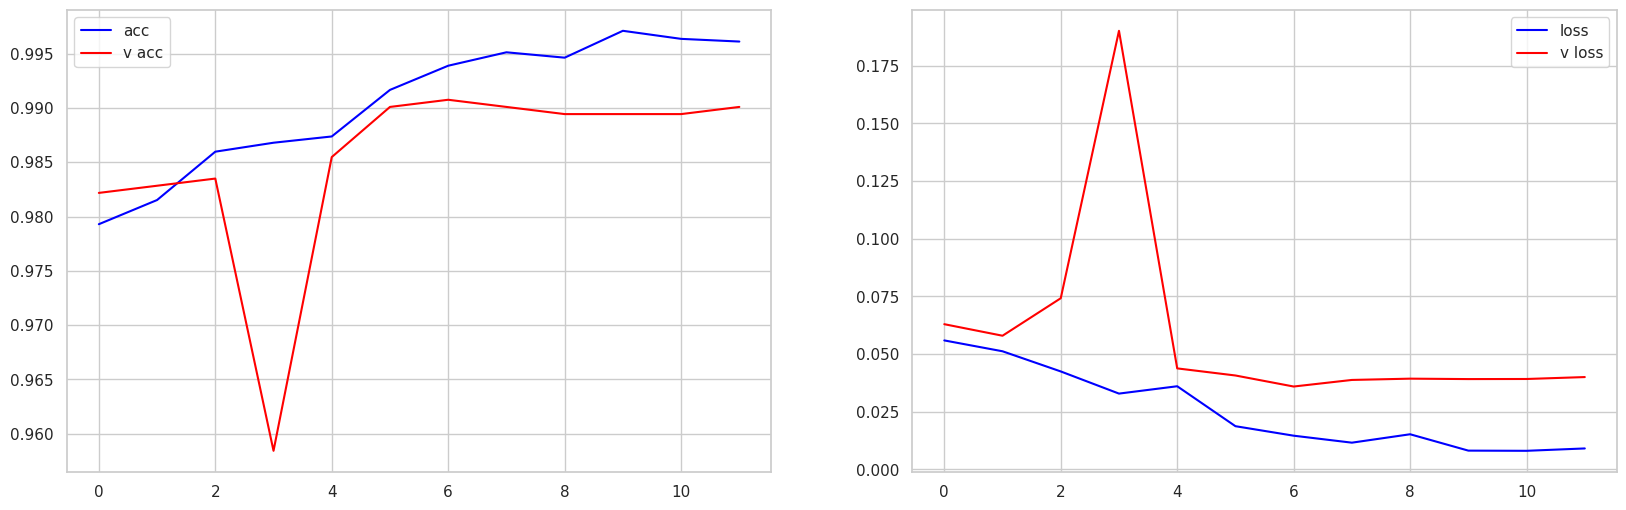

In [35]:
epoch_viewer(history)

In [36]:
pred_probs = best_model.predict(valid_gen)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = valid_gen.classes
target_names = list(valid_gen.class_indices.keys())  
print("Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=target_names))

95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 112ms/step
Classification Report:

                 precision    recall  f1-score   support

          COVID       0.98      0.99      0.99       361
         Normal       1.00      0.99      0.99      1019
Viral Pneumonia       0.98      0.99      0.98       135

       accuracy                           0.99      1515
      macro avg       0.99      0.99      0.99      1515
   weighted avg       0.99      0.99      0.99      1515



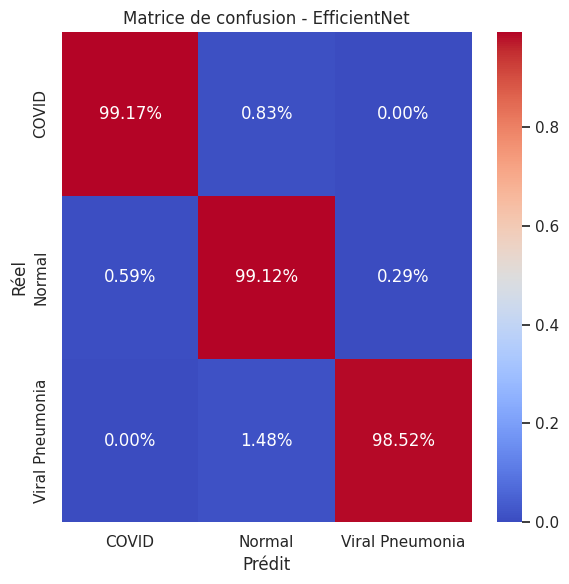

In [37]:
cm = confusion_matrix(true_labels, pred_labels)
labels = target_names

plot_confusion_matrix(cm, labels, normalize=True, title="Matrice de confusion - EfficientNet", cmap="coolwarm")

In [38]:
best_model.save("/kaggle/working/efficientnet_finetuned.h5")

## Qu’est-ce que le Fine-Tuning ?

Le *fine-tuning* est une étape d’entraînement complémentaire qui consiste à **affiner un modèle pré-entraîné** sur une nouvelle tâche plus spécifique.

Contrairement à l'entraînement initial (ex. sur ImageNet, avec des millions d’images), le fine-tuning s’appuie sur **un jeu de données plus restreint et spécialisé**, comme ici des radiographies thoraciques.

L'idée centrale :  
> **Adapter un modèle générique à un contexte particulier sans oublier ce qu’il a déjà appris.**

Concrètement, cela revient à :
- **dégeler** (partiellement ou totalement) les couches profondes du modèle,
- **réentraîner ces couches** sur nos données spécifiques,
- tout en conservant la majorité des poids appris sur le corpus initial.

Cette approche est très utilisée en vision par ordinateur et en NLP.  
Par exemple :
- Adapter un modèle pré-entraîné sur des images générales à la détection d’organes en imagerie médicale,
- Ou affiner un modèle NLP pour classer des commentaires client selon leur tonalité.

Dans notre cas, nous allons **dégeler le backbone EfficientNetB0** pour l’adapter aux radiographies pulmonaires, tout en bénéficiant de sa capacité d'extraction de caractéristiques issue d’ImageNet.


In [39]:
early_stopping = EarlyStopping(patience=5, min_delta=0.0005, mode="min", monitor="val_loss", restore_best_weights=True)

reduce_learning_rate = ReduceLROnPlateau(monitor="val_loss", patience=3, min_delta=0.01, factor=0.1, cooldown=4)

train_labels = train_gen.classes
class_labels = np.unique(train_labels) 
class_weights = class_weight.compute_class_weight("balanced", classes=class_labels, y=train_labels)
class_weights_dict = dict(zip(class_labels, class_weights))

In [40]:
for layer in best_model.layers[:-50]:
    layer.trainable = False
for layer in best_model.layers[-50:]:
    layer.trainable = True
    
best_model.compile(
    optimizer=Adam(learning_rate=1e-5),  
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_finetune = best_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_learning_rate]
)

Epoch 1/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 101s 87ms/step - accuracy: 0.9941 - loss: 0.0154 - val_accuracy: 0.9908 - val_loss: 0.0415 - learning_rate: 1.0000e-05
Epoch 2/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 45s 59ms/step - accuracy: 0.9964 - loss: 0.0080 - val_accuracy: 0.9908 - val_loss: 0.0438 - learning_rate: 1.0000e-05
Epoch 3/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 46s 60ms/step - accuracy: 0.9963 - loss: 0.0086 - val_accuracy: 0.9908 - val_loss: 0.0426 - learning_rate: 1.0000e-05
Epoch 4/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 46s 60ms/step - accuracy: 0.9963 - loss: 0.0071 - val_accuracy: 0.9901 - val_loss: 0.0459 - learning_rate: 1.0000e-05
Epoch 5/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 48s 63ms/step - accuracy: 0.9952 - loss: 0.0097 - val_accuracy: 0.9901 - val_loss: 0.0455 - learning_rate: 1.0000e-06
Epoch 6/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 47s 61ms/step - accuracy: 0.9950 - loss: 0.0071 - val_accuracy: 0.9908 - val_loss: 0.0441 - learning_rate: 1.0000e-06


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

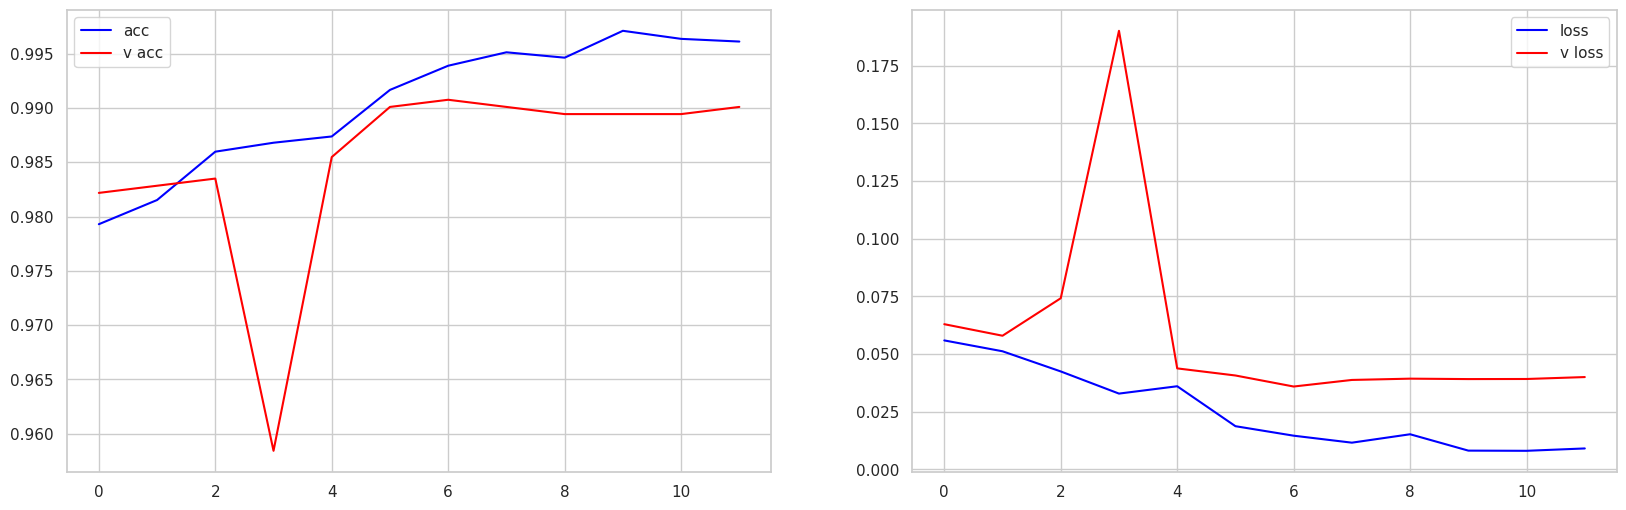

In [41]:
epoch_viewer(history)

In [42]:
pred_probs = best_model.predict(valid_gen)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = valid_gen.classes
target_names = list(valid_gen.class_indices.keys())  
print("Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=target_names))

95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step
Classification Report:

                 precision    recall  f1-score   support

          COVID       0.98      0.99      0.99       361
         Normal       1.00      0.99      0.99      1019
Viral Pneumonia       0.98      0.99      0.98       135

       accuracy                           0.99      1515
      macro avg       0.99      0.99      0.99      1515
   weighted avg       0.99      0.99      0.99      1515



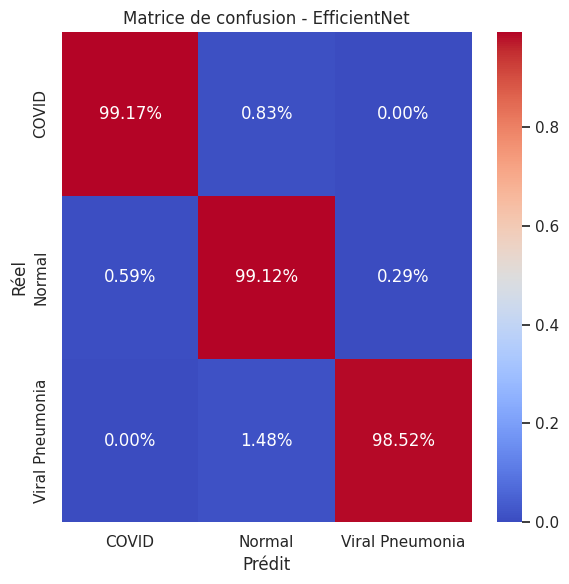

In [43]:
cm = confusion_matrix(true_labels, pred_labels)
labels = target_names

plot_confusion_matrix(cm, labels, normalize=True, title="Matrice de confusion - EfficientNet", cmap="coolwarm")

In [45]:
best_model.save("/kaggle/working/efficientnet_optimized.h5")

In [15]:
from tensorflow.keras.models import load_model
best_model = load_model("/kaggle/input/efficientnet/keras/default/1/efficientnet_final.h5")

I0000 00:00:1749536734.856611      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749536734.857296      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [24]:
# Fonction pour créer un modèle Keras qui retourne à la fois la sortie d'une couche convolutionnelle et la prédiction finale
def get_resnet_gradcam_model(model, layer_name="conv5_block3_out"):
    conv_layer = model.get_layer(layer_name).output  # Récupère la sortie de la couche spécifiée
    predictions = model.output  # Récupère la sortie finale (prédictions du modèle)
    return tf.keras.Model(inputs=model.input, outputs=[conv_layer, predictions])  # Nouveau modèle pour le Grad-CAM

# Fonction qui génère une heatmap Grad-CAM à partir d'une image et d'un modèle
def make_gradcam_heatmap(img_array, grad_model, class_index=None):
    img_tensor = tf.convert_to_tensor(img_array[np.newaxis, ...], dtype=tf.float32)  # Ajoute une dimension batch

    with tf.GradientTape() as tape:  # Enregistre les opérations pour calculer les gradients
        conv_output, predictions = grad_model(img_tensor)  # Passe l'image dans le modèle modifié
        if class_index is None:  # Si la classe n'est pas spécifiée
            class_index = tf.argmax(predictions[0])  # On prend celle avec la probabilité la plus haute
        loss = predictions[:, class_index]  # La "perte" pour cette classe spécifique

    grads = tape.gradient(loss, conv_output)  # Calcule les gradients de la couche convolutionnelle par rapport à la perte

    if grads is None:
        raise RuntimeError("Gradient is None — check layer connectivity.")  # Erreur si le gradient n’a pas pu être calculé

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Moyenne des gradients pour chaque canal
    conv_output = conv_output[0]  # Supprime la dimension batch

    # Multiplie chaque canal de la sortie convolutionnelle par l'importance du gradient
    heatmap = tf.reduce_sum(conv_output * pooled_grads, axis=-1)

    # Normalise la heatmap entre 0 et 1
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

# Superpose la heatmap sur l'image d'origine
def overlay_gradcam(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # Redimensionne la heatmap à la taille de l'image
    heatmap = np.uint8(255 * heatmap)  # Convertit en valeurs 0-255
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Applique une colormap "jet"

    # Combine l'image originale et la heatmap colorée
    overlay = cv2.addWeighted(img.astype("uint8"), 1.0, heatmap_color, alpha, 0)
    return overlay

# Affiche les résultats Grad-CAM pour plusieurs images extraites d’un generator
def show_gradcam_from_generator(generator, model, layer_name="conv5_block3_out", class_names=None):
    grad_model = get_resnet_gradcam_model(model, layer_name)
    images, labels = next(generator)  # Récupère un batch d'images et de labels

    plt.figure(figsize=(15, 15))
    for i in range(min(9, len(images))):  # Affiche jusqu'à 9 images
        img = images[i]
        label = labels[i]
        img_rgb = (img * 255).astype("uint8") if img.max() <= 1.0 else img.astype("uint8")  # Conversion pour affichage

        heatmap = make_gradcam_heatmap(img, grad_model)  # Calcule la heatmap
        cam = overlay_gradcam(img_rgb, heatmap)  # Superpose la heatmap à l’image

        plt.subplot(3, 3, i+1)
        plt.imshow(cam)
        title = class_names[int(label)] if class_names else str(label)  # Affiche le nom de la classe
        plt.title(f"Label: {title}", fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Affiche chaque image avec sa version originale, heatmap seule et overlay Grad-CAM
def show_gradcam_triplets(generator, model, layer_name="conv5_block3_out", class_names=None, samples=5):
    grad_model = get_resnet_gradcam_model(model, layer_name)
    images, labels = next(generator)

    samples = min(samples, len(images))  # Prend au maximum 'samples' images

    plt.figure(figsize=(15, samples * 3))

    for i in range(samples):
        img = images[i]
        label = labels[i]
        img_rgb = (img * 255).astype("uint8") if img.max() <= 1.0 else img.astype("uint8")

        heatmap = make_gradcam_heatmap(img, grad_model)
        cam_overlay = overlay_gradcam(img_rgb, heatmap)

        class_label = class_names[int(label)] if class_names else str(label)

        # Image originale
        plt.subplot(samples, 3, i * 3 + 1)
        plt.imshow(img_rgb)
        plt.title(f"Original ({class_label})")
        plt.axis("off")

        # Heatmap brute
        plt.subplot(samples, 3, i * 3 + 2)
        plt.imshow(heatmap, cmap='jet')
        plt.title("Grad-CAM Heatmap")
        plt.axis("off")

        # Heatmap superposée
        plt.subplot(samples, 3, i * 3 + 3)
        plt.imshow(cam_overlay)
        plt.title("Overlay")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

def show_gradcam_per_class(generator, model, layer_name="conv5_block3_out", class_names=None, samples_per_class=2):
    grad_model = get_resnet_gradcam_model(model, layer_name)

    # Dictionnaire pour stocker les images par classe
    selected_images = {i: [] for i in range(len(class_names))}

    # Continuer à extraire des batches jusqu'à obtenir le bon nombre d'images par classe
    while any(len(v) < samples_per_class for v in selected_images.values()):
        images, labels = next(generator)
        for img, label in zip(images, labels):
            label_idx = int(label)
            if len(selected_images[label_idx]) < samples_per_class:
                selected_images[label_idx].append((img, label_idx))

    # Affichage
    total = samples_per_class * len(class_names)
    plt.figure(figsize=(15, 5 * samples_per_class))

    i = 0
    for class_idx, image_list in selected_images.items():
        for img, label in image_list:
            img_rgb = (img * 255).astype("uint8") if img.max() <= 1.0 else img.astype("uint8")
            heatmap = make_gradcam_heatmap(img, grad_model, class_index=label)
            cam = overlay_gradcam(img_rgb, heatmap)

            plt.subplot(samples_per_class, len(class_names), i + 1)
            plt.imshow(cam)
            plt.title(f"{class_names[label]}")
            plt.axis("off")
            i += 1

    plt.tight_layout()
    plt.show()


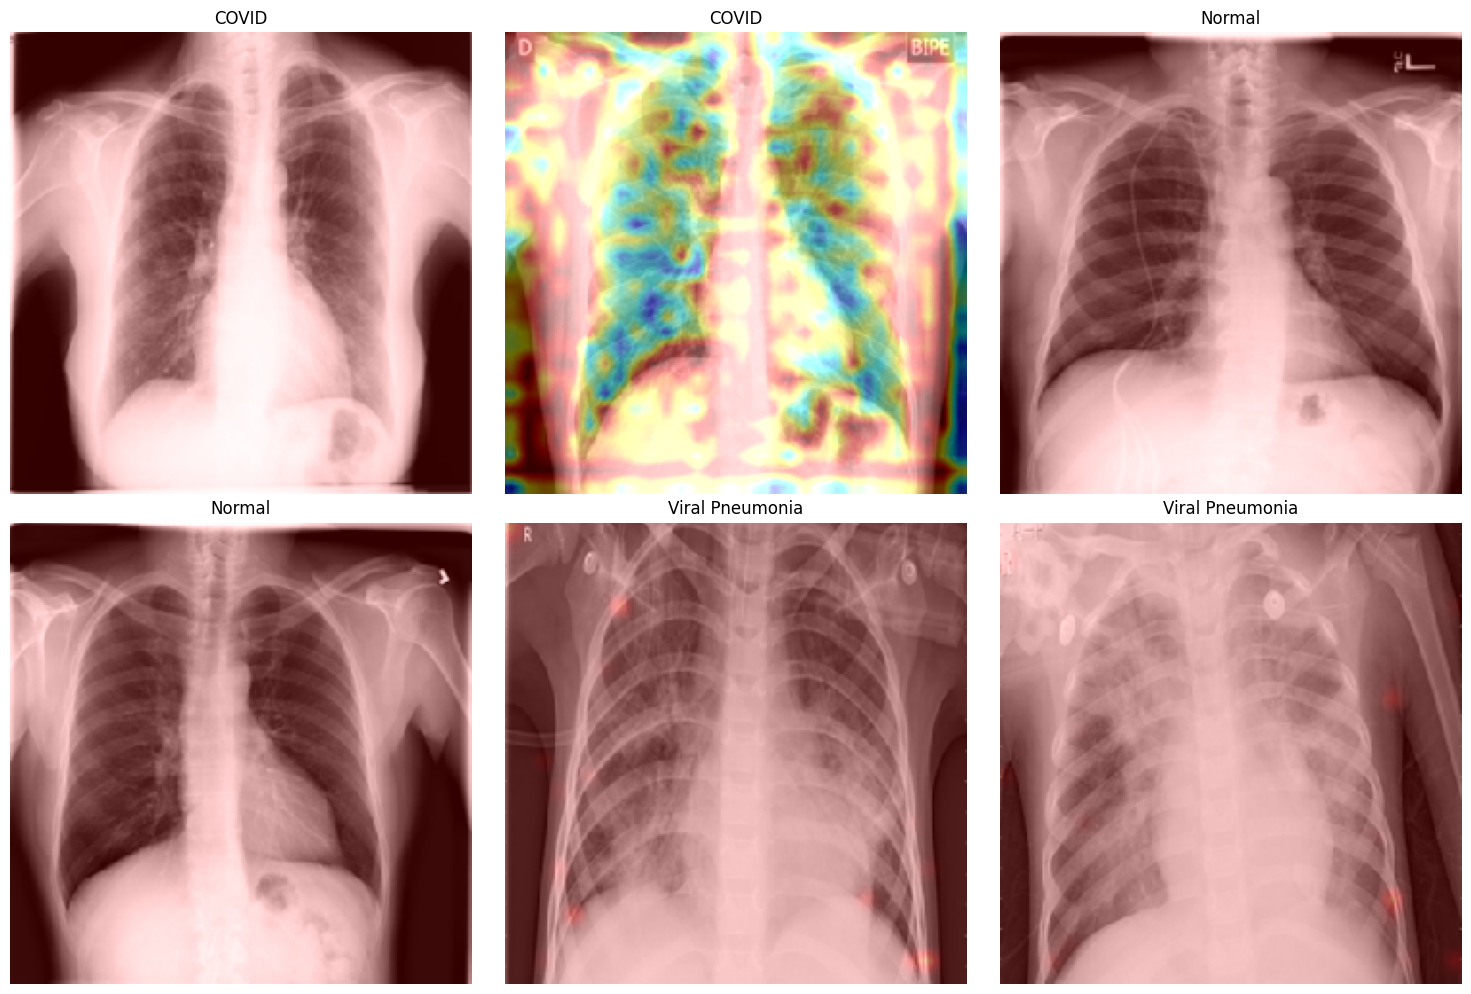

In [26]:
class_names = list(train_gen.class_indices.keys())
show_gradcam_per_class(test_gen, best_model, class_names=class_names, samples_per_class=2, layer_name="block3a_project_conv")

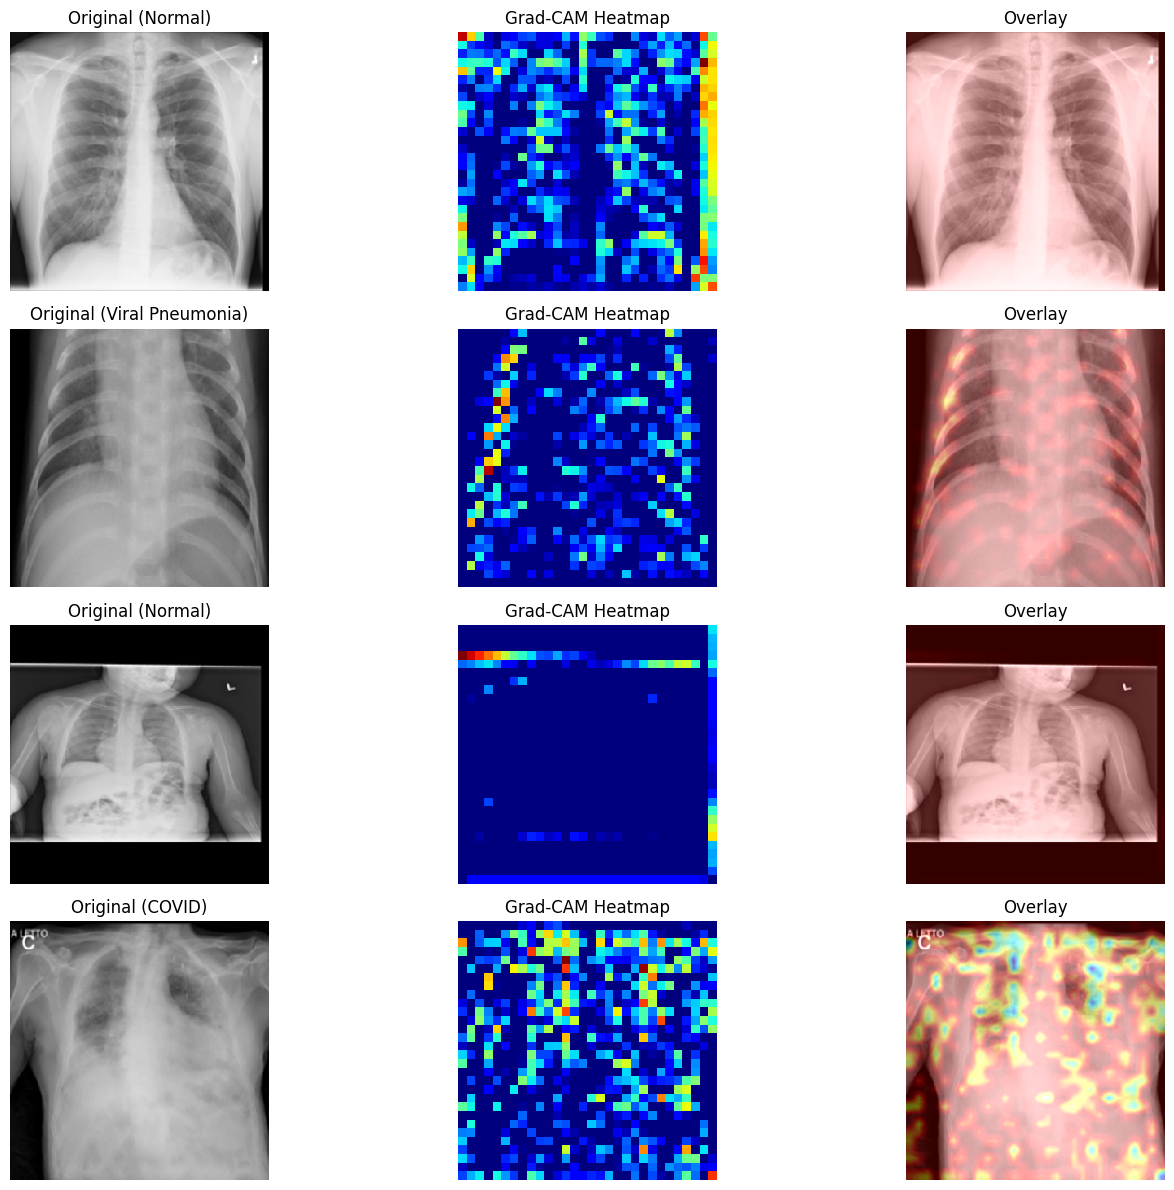

In [29]:
show_gradcam_triplets(test_gen, best_model, class_names=class_names, samples=5, layer_name="block3a_project_conv")